# Solar Energy Forecasting with Machine Learning

---
### Background

The transportation sector in the United States currently accounts for 37% of the [energy-consumption](https://www.eia.gov/energyexplained/us-energy-facts/) and [CO2 emissions](https://www.eia.gov/totalenergy/data/monthly/pdf/flow/CO2-spaghettichart-2021.pdf) in the United States. With the adoption of EVs gaining significant momentum, sustainably sourcing our energy has never been more crucial. Though, due to the nature of solar energy being dependent on variable weather conditions, it can be difficult to predict the energy output. This poses an issue for power grid operators which need to balance energy supply and demand, failure to do so leading to potentially dangerous outages.

### Project Goal

In this project, I aim to address this challenge by developing a robust solar forecaster which utilizes machine learning to accurately predict solar energy outputs. This will be accomplished by evaluating the performance of several regressive machine learning techniques including K-Nearest Neighbor, Deep Learning, Gradient Boosting, and Random Forest.

### The Data
The dataset I'll be using to train the forecaster with is a collection of historical weather and solar energy output data. The dataset contains the following information:

* distance to solar noon (radians)
* daily average temperature (Celsius)
* daily average wind direction (degrees)
* daily average wind speed (meters per second)
* sky cover (0 totally clear - 4 completely covered)
* visibility (kilometers)
* humidity (percentage)
* average wind speed during 3-hour period (meters per second)
* average pressure during the 3-hour period (mercury inches)
* power generated for each 3-hour period (Joules)

### Data Import and Cleaning
The data contains some null values so in order to make sure this doesnt affect the final result, we'll be utilizing sklearn's SimpleImputer which replaces null values with its columns mean value.

In [41]:
import pandas as pd
from sklearn.impute import SimpleImputer
import numpy as np

# Import data and read with pandas
df = pd.read_csv("/Users/roycesalah/Desktop/Projects/Solar Power Forecasting with Machine Learning/solarpowergeneration.csv")

# Change the distance-to-solar-noon values before solar noon have a negative value differentiate morning measurements
for i in range(-(-df.shape[0]//4)):
    for j in range(4):
        ind = i*8 + j
        if ind > df.shape[0]-1:
            break
        df.loc[ind,'distance-to-solar-noon'] = -df.loc[ind,'distance-to-solar-noon']

# Clean Null Values with SimpleImputer (estimates NaN values based on mean col vals)
imputer = SimpleImputer(missing_values=np.NaN,strategy='mean')
for colnam in df.columns.to_list():
    df[colnam] = imputer.fit_transform(df[colnam].values.reshape(-1,1))[:,0]

### Data Exploration
Now that the data has been successfully imported and cleaned, we can look at some of the characteristics of the data itself.

In [42]:
# Data statistics
print(df.describe().transpose())

                              count         mean           std        min  \
distance-to-solar-noon       2920.0    -0.021219      0.584602  -1.066087   
temperature                  2920.0    58.468493      6.841200  42.000000   
wind-direction               2920.0    24.953425      6.915178   1.000000   
wind-speed                   2920.0    10.096986      4.838185   1.100000   
sky-cover                    2920.0     1.987671      1.411978   0.000000   
visibility                   2920.0     9.557705      1.383884   0.000000   
humidity                     2920.0    73.513699     15.077139  14.000000   
average-wind-speed-(period)  2920.0    10.129154      7.260303   0.000000   
average-pressure-(period)    2920.0    30.017760      0.142006  29.480000   
power-generated              2920.0  6979.846233  10312.336413   0.000000   

                                   25%        50%           75%           max  
distance-to-solar-noon       -0.484744   -0.01673      0.478815      1.1

Using the pandas dataframe describe method, we can see that the dataset consists of 2,920 datapoints. Some interesting characteristics of the data are that while the average power generated for a 3-hour period is 6,979, it has a large amount of variability with a standard deviation of 10,312 and a maximum of 36,580. This can be attributed to the lack of energy generation at night, in which there's no sunlight for the solar powers to generate energy from. Another interesting characteristic of this data is that visibility is overwhelmingly clear for a majority of the points. This might pose a problem for the trained model when predicting datapoints with lower visibility.

Next, to visualize relationships between the variables we'll be constructing a correlation heatmap utilizing seaborn's heatmap and panda's correlation function.

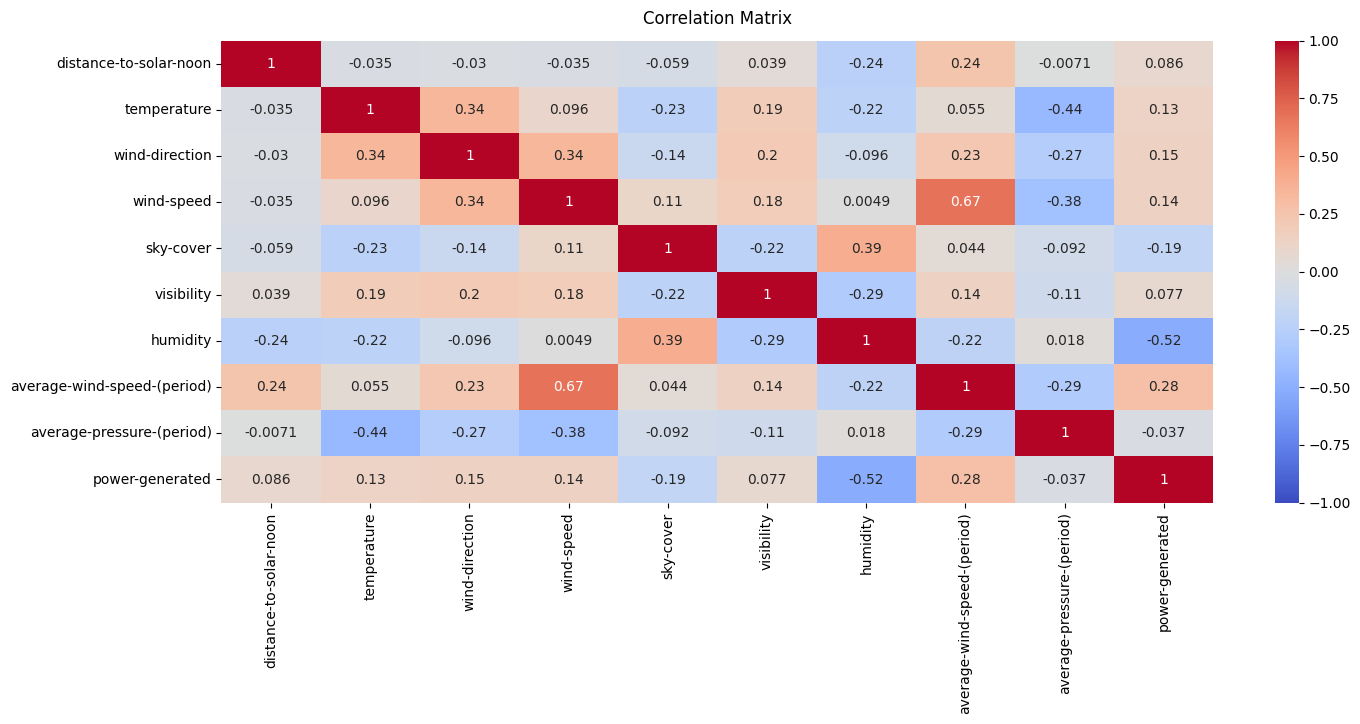

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
# Correlation Matrix
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True,cmap='coolwarm')
heatmap.set_title('Correlation Matrix', fontdict={'fontsize':12}, pad=12)
plt.show()

The correlation matrix presents a few interesting relationships between the variables, particularly their effects on power generated. The variable with the highest correlation with power generation is humidity at -0.52, meaning that there is a trend that as humidity increases, power generation decreases. After some research, I learned that this is due to the collection of water vapor from humid air on the panel which can sunlight to be refracted away from the panel itself.

In contrast to the negative correlation with humidity, wind speed and its direction are both positively correlated with power generation. This increase in power generation is caused by an increase in efficiency from wind-cooling, particularly from southern winds.

One last important "anomaly" in this matrix to note is that power generation has nearly no correlation with distance to solar noon. Because values before noon are negative datapoints and those after are positive, they're effectively canceling each other out; instead, we can see the actual correlation by plotting the datapoints. From the scatter plot, we can see that peak power generation occurs as distance to solar noon approaches zero (noon).

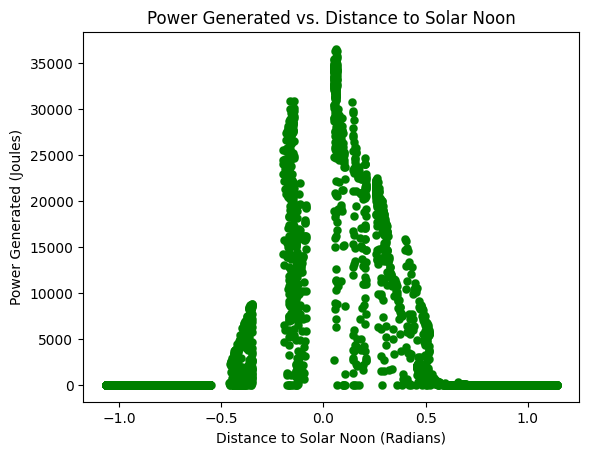

In [44]:
plt.scatter(x=df['distance-to-solar-noon'],y=df['power-generated'],linewidths=.1,c='green',marker='o')
plt.title('Power Generated vs. Distance to Solar Noon')
plt.xlabel('Distance to Solar Noon (Radians)')
plt.ylabel('Power Generated (Joules)')
plt.show()

### Model Training and Selection
Before beginning model training and selection, we'll need to separate the data into a training set to train the model and a test set to evaluate the performance.

In [45]:
from sklearn.model_selection import train_test_split
# Percentage of dataset used for training
TrainingSize = 0.7

# Separate dataframe into variables (i.e. weather conditions) and output (i.e. energy generated)
variables = df.iloc[:,:9].values.tolist()
output = df.iloc[:,9:].values.tolist()

xtrain, xtest, ytrain, ytest = train_test_split(variables,output,train_size=TrainingSize)

#### K-Nearest Neighbor
The first model we'll be implementing is K-Nearest Neighbor regression with the sklearn library. To implement this model, it needs an integer K to determine how many of a point's nearest neighbors to utilize to predict a value. To resolve this, we'll simply be running the model with various K-values and selecting the K with the highest performance. This would typically be an intensive and inefficient way of finding an optimal K-value and is only made possible in this project due to the small dataset.

In [52]:
from copy import deepcopy
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

# Find optimal k value
KNNopt = None
RMSEopt = float('inf')
R2opt = 0
nn = 0

for i in range(3,50):
    KNN = KNeighborsRegressor(n_neighbors=i)
    KNN.fit(xtrain,np.array(ytrain).ravel())
    KNN_ypred = KNN.predict(xtest)
    RMSE = metrics.mean_squared_error(ytest, KNN_ypred)**.5
    R2 = metrics.r2_score(ytest, KNN_ypred,force_finite=True)
    if RMSE < RMSEopt:
        KNNopt = deepcopy(KNN)
        nn = i
        RMSEopt = RMSE
        R2opt = R2
print(f"K-Nearest Neighbor \n    Optimal-k: {nn} \n    RMSE: {RMSEopt:.5f} \n    R2: {R2opt:.5f}")

K-Nearest Neighbor 
    Optimal-k: 17 
    RMSE: 6980.68132 
    R2: 0.52685


#### K-Nearest Neighbor with Decomposition
In an attempt to optimize the KNN regressor, we'll be testing the effects of the following various dimensionality reduction techniques in conjunction with the KNN model: Factor Analysis, Principle Component Analysis, Linear Discriminant Analysis, and Neighborhood Components Analysis.

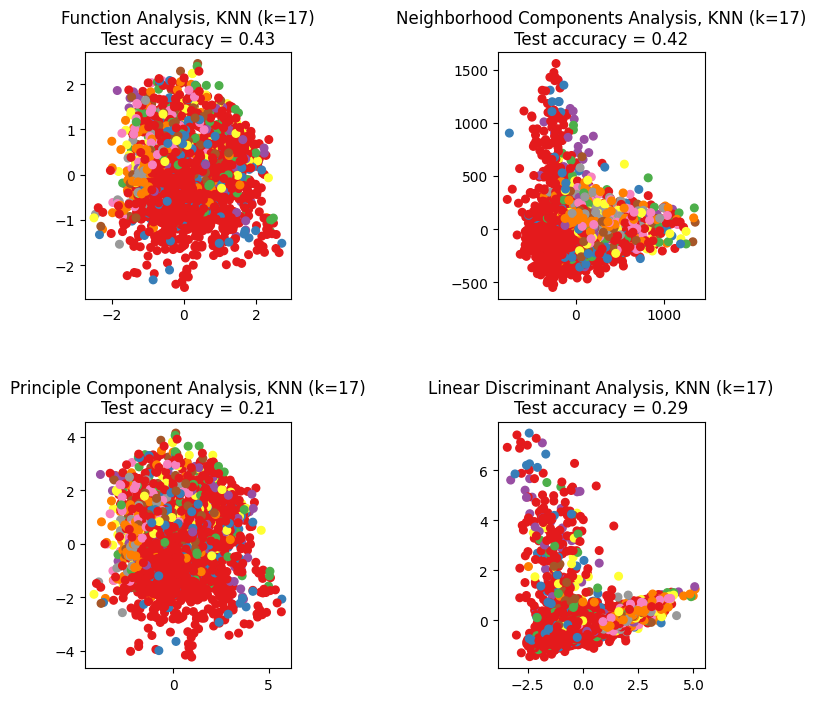

In [83]:
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.decomposition import FactorAnalysis, PCA

# Make Decomposition Analysis pipelines
FA = make_pipeline(StandardScaler(),FactorAnalysis(n_components=nn))
NCA = make_pipeline(StandardScaler(),NeighborhoodComponentsAnalysis(n_components=2))
PCA_ = make_pipeline(StandardScaler(),PCA(n_components=2))
LDA = make_pipeline(StandardScaler(),LinearDiscriminantAnalysis(n_components=2))

models = [("Function Analysis",FA),
          ("Neighborhood Components Analysis",NCA),
          ("Principle Component Analysis",PCA_),
          ("Linear Discriminant Analysis",LDA)
          ]

knn = KNeighborsRegressor(n_neighbors=17)
fig,axs = plt.subplots(2,2)
fig.set_figheight(8)
fig.set_figwidth(8)

# plt.subplot(1, 3, i + 1, aspect=1)
plotind = [(0,0),(0,1),(1,0),(1,1)]

for i,(model_name,model) in enumerate(models):

    # Fit the method's model
    model.fit(xtrain, np.array(ytrain).ravel())

    # Fit a nearest neighbor classifier on the embedded training set
    knn.fit(model.transform(xtrain), ytrain)

    # Compute the nearest neighbor accuracy on the embedded test set
    acc_knn = knn.score(model.transform(xtest), ytest)

    # Embed the data set in 2 dimensions using the fitted model
    X_embedded = model.transform(variables)

    # Plot the projected points and show the evaluation score
    j,k = plotind[i]
    axs[j,k].scatter(X_embedded[:, 0], X_embedded[:, 1], c=output, s=30, cmap="Set1")
    axs[j,k].set_title(
            "{}, KNN (k={})\nTest accuracy = {:.2f}".format(model_name, nn, acc_knn)
        )
fig.subplots_adjust(hspace=.5,wspace=1)
plt.show()


#### Random Forest

In [82]:
import sklearn.ensemble as ensemble
RF = ensemble.RandomForestRegressor(n_estimators=100,criterion='squared_error',max_depth=2)
RF.fit(xtrain,np.array(ytrain).ravel())
RF_ypred = RF.predict(xtest)
RF_R2 = metrics.r2_score(ytest, RF_ypred,force_finite=True)
RF_RMSE = metrics.mean_squared_error(ytest, RF_ypred)**0.5
print(f"Random Forest \n    RF_RMSE: {RF_RMSE:.5f} \n    RF_R2: {RF_R2:.5f}")

Random Forest 
    RF_RMSE: 6521.20855 
    RF_R2: 0.58709


#### Gradient Boosting

In [97]:
GB = ensemble.GradientBoostingRegressor(max_depth=2,random_state=0)
GB.fit(xtrain,np.array(ytrain).ravel())
GB_ypred = GB.predict(xtest)
GB_R2 = metrics.r2_score(ytest, GB_ypred,force_finite=True)
GB_RMSE = metrics.mean_squared_error(ytest, GB_ypred)**0.5
print(f"Gradient Boosting \n    GB_RMSE: {GB_RMSE:.5f} \n    GB_R2: {GB_R2:.5f}")

Gradient Boosting 
    GB_RMSE: 3176.43511 
    GB_R2: 0.90203


#### Deep Learning

In [69]:
import tensorflow as tf
import tensorflow_addons as tfa


# Create keras Sequential model
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(xtrain)

DL_model = tf.keras.Sequential(
    [
    # Normalization Layer to normalize inputs between 0-1.0
    normalizer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    # Output a single number (energy generated)
    tf.keras.layers.Dense(units=1)
    ]
)
DL_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=tf.keras.losses.mean_absolute_error,
    metrics=[tfa.metrics.RSquare()]
    )

# Fit model to training data
DL_model.fit(xtrain, ytrain, epochs=10, verbose=0)

ypred = DL_model.predict(xtest)

DL_R2 = metrics.r2_score(ytest, ypred,force_finite=True)
DL_RMSE = metrics.mean_squared_error(ytest, ypred)**0.5

print(f"Deep Neural Network \n    DL_RMSE: {DL_RMSE:.5f}\n    DL_R^2: {DL_R2:.5f}")

2023-03-15 17:35:43.966326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-15 17:35:43.989295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-15 17:35:44.696596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 0s 3ms/step
Deep Neural Network 
    DL_RMSE: 3323.99623
    DL_R^2: 0.89272


2023-03-15 17:35:49.218950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


#### Stacked Model
Each model tested so far has its strengths and weaknesses and the approach we'll be attemping next will attempt to leverage the strengths of each model and combine them into one stacked model. Because of compatibility issues between TensorFlow and sklearn, the stacked model we'll be implementing will be a collection of only the KNN, Random Forest, and Gradient Boosting models. To construct the model, we'll be leveraging sklearn's StackingRegressor function.

In [111]:
from sklearn.linear_model import Lasso
stacked = ensemble.StackingRegressor(estimators=[('gradientbooster',ensemble.GradientBoostingRegressor(max_depth=2,random_state=0)),
                                                 ('randomforest',ensemble.RandomForestRegressor(n_estimators=100,criterion='squared_error',max_depth=2)),
                                                 ('k-nearest',KNeighborsRegressor(n_neighbors=3))],final_estimator=Lasso())
stack_ypred = stacked.fit(xtrain,np.array(ytrain).ravel()).predict(xtest)
stack_R2 = metrics.r2_score(ytest, stack_ypred,force_finite=True)
stack_RMSE = metrics.mean_squared_error(ytest, stack_ypred)**0.5
print(f"Stacked Model \n    RMSE: {stack_RMSE:.5f}\n    R^2: {stack_R2:.5f}")

Stacked Model 
    RMSE: 3096.06650
    R^2: 0.90693


The stacked model performed marginally better than Gradient Boosting in both its R squared and root means squared error.
Stacked models often work best when all the models have similar performance, and since Gradient Boosting significantly outperformed KNN and RandomForest it may be why the difference in performance was small. Despite the lack of the deep learning model, the stacked model still performed better than any other individual model.


### Conclusions
In this project, we evaluated several machine learning models for predicting solar energy outputs and found that Gradient Boosting was the most accurate, with the Deep Learning model coming in a close second. However, the stacked model performed best overall, combining the strengths of multiple algorithms to improve accuracy and robustness.

While attempts at improving the K-Nearest Neighbor model's accuracy with dimensionality reduction techniques ultimately failed, further improvements may be possible by testing different methods or increasing the number of dimensions that the data is reduced to.

Future improvements on the final stacked model could be made by integrating the Deep Learning model using the scikeras Keras wrapper, potentially leading to even more accurate predictions. Overall, the insights gained from this project provide a strong foundation for the development of a robust solar forecaster that can facilitate the transition towards a more sustainable energy future.

